# Playground

The goal of this project is to generate medical reports from X-ray images. The images are in grayscale. We will work on a few so-called *image2text* models.

In [341]:
# @TODO: extract tags?

In [342]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("./code")

First the imports.

In [343]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import logging
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

import spacy
#!python -m spacy download en_core_web_lg

import stanza
stanza.download("en")

from utils import *
from dataset import *
from plots import *

fix_seed()

01:38:20 - INFO: Downloading default packages for language: en (English) ...
01:38:22 - INFO: File exists: /home/rasmus/stanza_resources/en/default.zip
01:38:29 - INFO: Finished downloading models and saved to /home/rasmus/stanza_resources.


## Load data

Let's load the metadata and the images.

In [344]:
REPORT_PATH = "./data/raw/reports"
IMAGE_PATH = "./data/raw/images"

In [345]:
metadata = load_reports(REPORT_PATH)
metadata.describe()

01:38:29 - INFO: found 3955 reports.


,image_name,comparison,indication,findings,impression
count,7470,6313,7311,6473,7418
unique,7470,394,2454,2553,1770
top,CXR82_IM-2350-3001.png,None.,Chest pain,The heart is normal in size. The mediastinum i...,No acute cardiopulmonary abnormality.
freq,1,1592,253,98,586


Notice, some of the text is censored by replacing words with "XXXX".

In [346]:
metadata.head()

,image_name,comparison,indication,findings,impression
0,CXR82_IM-2350-3001.png,Chest x-XXXX XXXX,PAIN IN THORACIC SPINE Pain started in leg are...,"No airspace disease, effusion or noncalcified ...",No acute cardiopulmonary abnormality.
1,CXR82_IM-2350-4001.png,Chest x-XXXX XXXX,PAIN IN THORACIC SPINE Pain started in leg are...,"No airspace disease, effusion or noncalcified ...",No acute cardiopulmonary abnormality.
2,CXR173_IM-0481-1001.png,None,Chest pain,Low lung volumes. Cardiomediastinal silhouette...,Low lung volumes. No acute cardiopulmonary fin...
3,CXR173_IM-0481-2001.png,None,Chest pain,Low lung volumes. Cardiomediastinal silhouette...,Low lung volumes. No acute cardiopulmonary fin...
4,CXR3676_IM-1829-0001-0001.png,Comparison is XXXX to XXXX examination dated X...,XXXX-year-old male with XXXX.,The cardiomediastinal silhouette appears irreg...,1. Redemonstration of diffuse bilateral pulmon...


The feature "findings" describes the radiologists observations. While "impression" is the final diagnosis / conclusion.
Let's define a report as the concatation of the findings and impression text.

In [401]:
def prepare_reports(metadata):
    reports = metadata["findings"].astype(str) + "\n" + metadata["impression"].astype(str)
    print(f"raw report length: {len(reports)}")

    reports.replace("[N|n]one", "", regex=True, inplace=True)
    reports = reports[reports != "\n"] # if both are None, then only "\n" remains
    reports = reports.rename("report")
    print(f"post-processing report length: {len(reports)}")

    return reports

In [402]:
reports = prepare_reports(metadata)
reports.head()
#pd.merge(metadata, report, left_index=True, right_index=True)

raw report length: 7470
post-processing report length: 7430


0    No airspace disease, effusion or noncalcified ...
1    No airspace disease, effusion or noncalcified ...
2    Low lung volumes. Cardiomediastinal silhouette...
3    Low lung volumes. Cardiomediastinal silhouette...
4    The cardiomediastinal silhouette appears irreg...
Name: report, dtype: object

In [349]:
reports.describe()

count                                                  7430
unique                                                 3066
top       The heart is normal in size. The mediastinum i...
freq                                                     96
Name: report, dtype: object

Let's load the images. The images have been cropped such that the width and height are the same. Afterwards, the images have been scaled to 256x256. 

In [350]:
N = 1500
np_images = load_images(metadata[:N], IMAGE_PATH, resized=(256, 256))
images = torch.tensor(np_images)

There are images from two views: frontal and lateral. It may be worth to include this information in the model. However, since it hasn't already been annotated, we will ignore it for now.

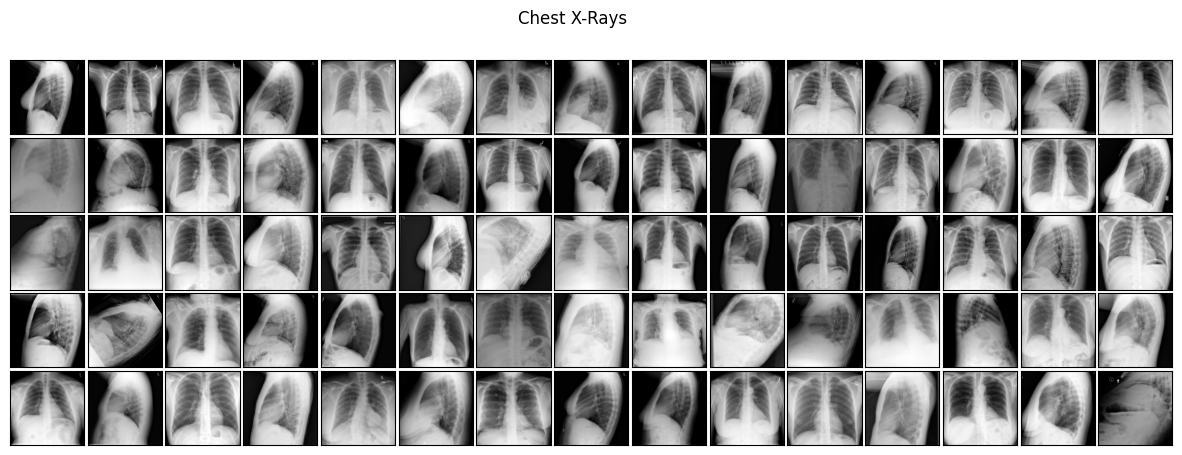

In [351]:
offset = 100
n_rows = 5
n_cols = 15

images_tiny = images[offset:offset+n_rows*n_cols]

plot_images_2d(images_tiny.reshape(n_rows, n_cols, *images_tiny.shape[1:]), "Chest X-Rays")

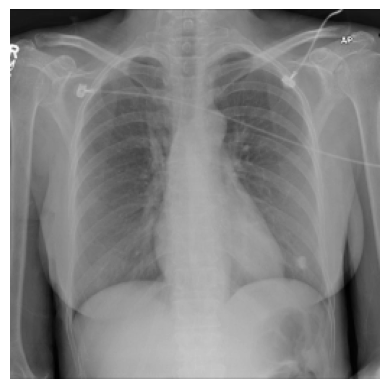

In [352]:
highlighted_sample = metadata.loc[metadata["image_name"] == "CXR21_IM-0729-1001-0001.png"]
highlighted_image = images[highlighted_sample.index]

plot_image(highlighted_image[0])

Time to plot a few random X-ray image and their corresponding reports!

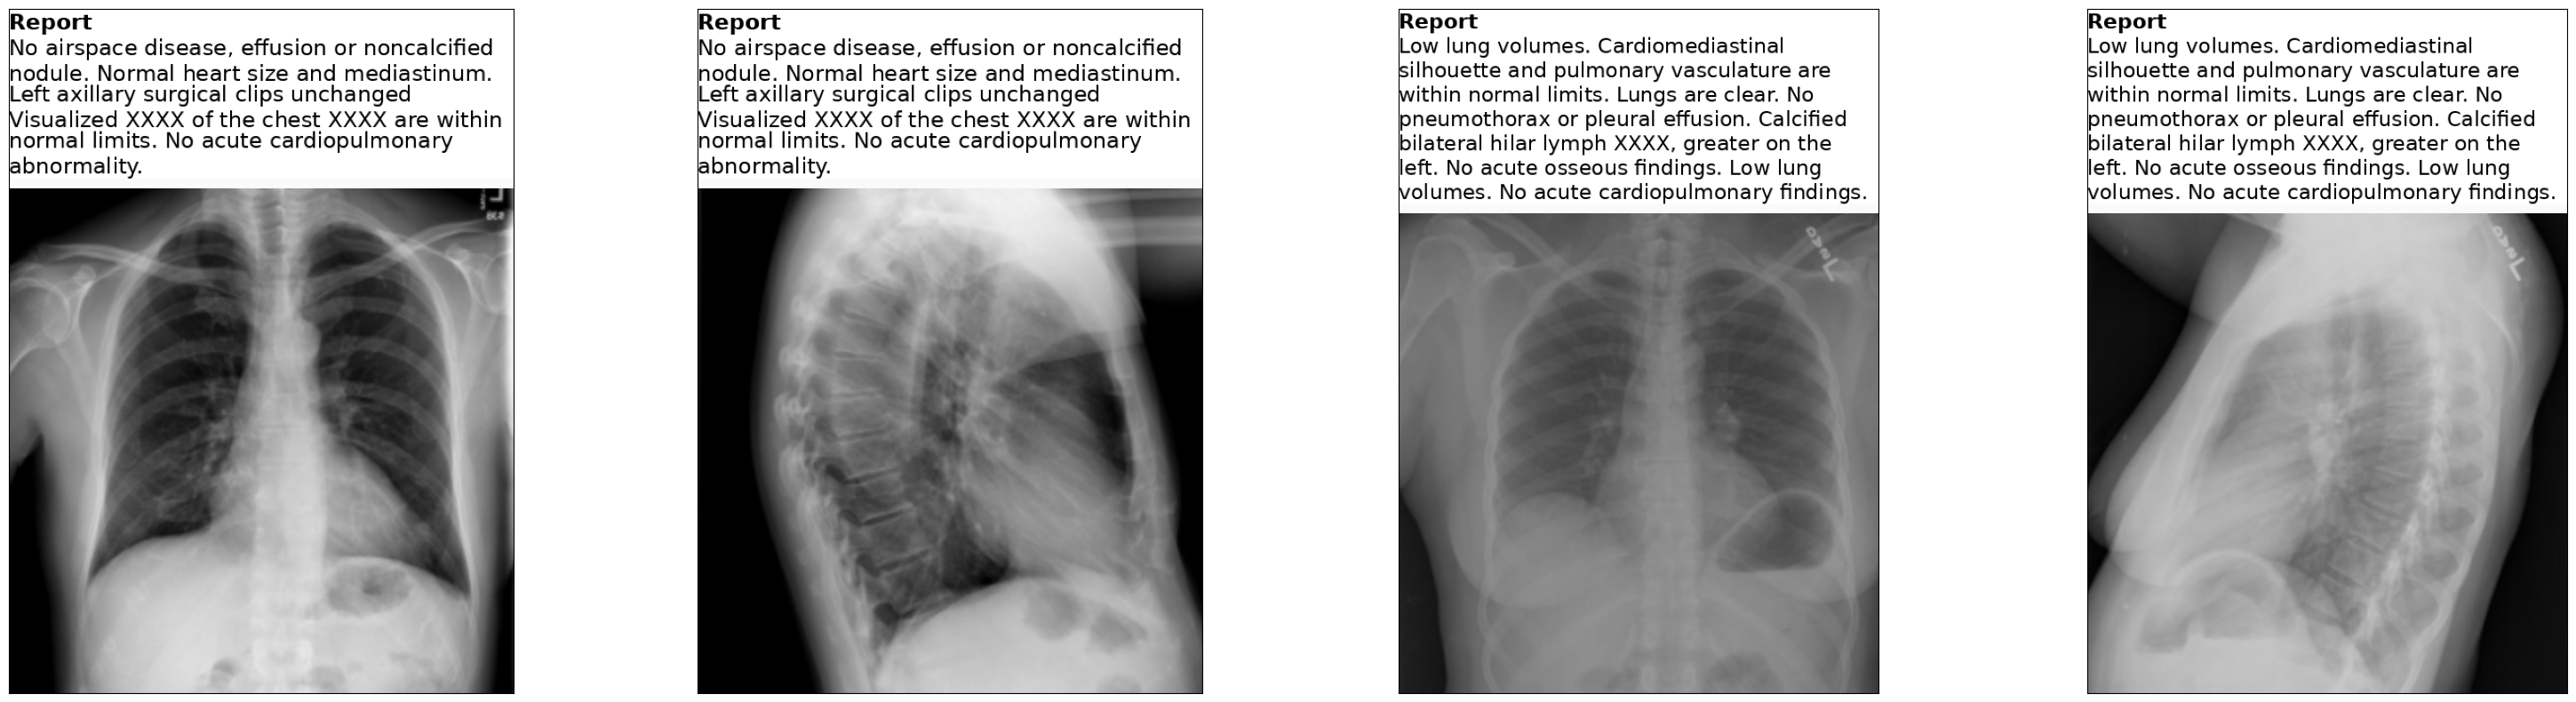

In [353]:
k = np.arange(4)#+1000 #1400

title = "Report"
extracted_textbodies = reports.iloc[k]
extracted_images = np_images[k]

plot_multiple_text_and_images(extracted_textbodies, title, extracted_images)

## Preprocessing

In [354]:
# references: https://arxiv.org/pdf/1711.08195v3.pdf, https://arxiv.org/pdf/2209.15323.pdf
# @TODO: embedding
# @TODO: attention (cross-attention) using tags
# @TODO: transformer model
# @TODO: compare against GPT-4 (with images) if possible

### Images

Let's, normalize the images to the range [0, 1].

In [355]:
images = images.type(torch.float32) / 255.

In [356]:
images.shape

torch.Size([1500, 256, 256])

### Text

In [407]:
def stanza_tokenizer():
    nlp = stanza.Pipeline(lang="en", processors="tokenize")
    return lambda text: [token.text for sentence in nlp(text).sentences for token in sentence.tokens]

In [408]:
def spacy_tokenizer():
    nlp = spacy.load('en_core_web_lg')
    return lambda text: [token.text for token in nlp(text)]

In [409]:
def tokenize(text, tokenizer):
    text = text.lower()
    tokens = tokenizer(text)
    return [token for token in tokens if token.isalpha()]

In [410]:
#tokenizer = spacy_tokenizer()
tokenizer = stanza_tokenizer()

tokenized_reports = reports.apply(lambda text : tokenize(text, tokenizer))

01:55:07 - INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


01:55:07 - INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

01:55:07 - INFO: Using device: cpu
01:55:07 - INFO: Loading: tokenize
01:55:07 - INFO: Done loading processors!


In [411]:
tokenized_reports.head()

0    [no, airspace, disease, effusion, or, noncalci...
1    [no, airspace, disease, effusion, or, noncalci...
2    [low, lung, volumes, cardiomediastinal, silhou...
3    [low, lung, volumes, cardiomediastinal, silhou...
4    [the, cardiomediastinal, silhouette, appears, ...
Name: report, dtype: object

In [412]:
tokenized_reports_lengths = tokenized_reports.apply(len)

print(f"Report length: {np.mean(tokenized_reports_lengths):.1f} +- {np.std(tokenized_reports_lengths):.1f} words.")
print(f"Report length boundaries: [{np.min(tokenized_reports_lengths):.1f}; {np.max(tokenized_reports_lengths):.1f}] words.")

Report length: 37.4 +- 19.6 words.
Report length boundaries: [3.0; 226.0] words.


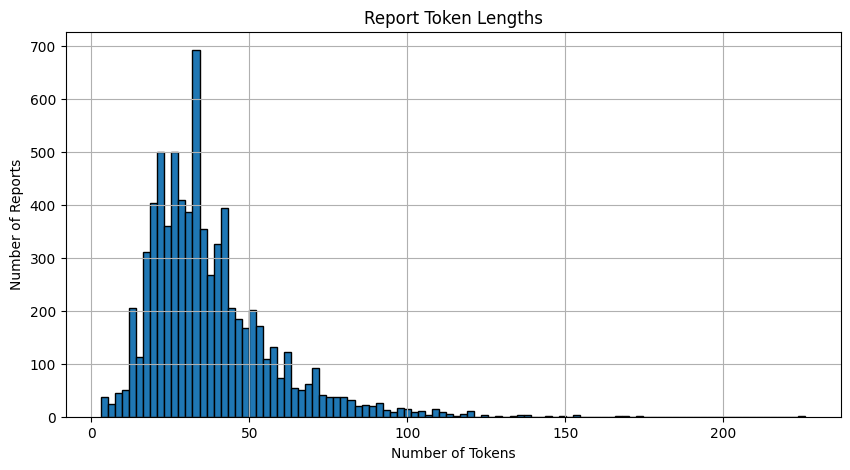

In [479]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(tokenized_reports_lengths, bins=100, histtype="bar", ec="black")
ax.set_title("Report Token Lengths")
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Number of Reports")
ax.grid()
plt.show()

In [413]:
def build_vocabulary(tokens):
    return set(["[UNK]", "[PAD]", "[START]", "[END]", "."]) | set(tokens)

In [414]:
def map_token_and_id(vocabulary):
    stabil_vocabulary = list(vocabulary)
    return {token: i for i, token in enumerate(stabil_vocabulary)}, {i: token for i, token in enumerate(stabil_vocabulary)}


def map_token_and_id_fn(vocabulary):
    token2id, id2token = map_token_and_id(vocabulary)
    return lambda token: token2id[token] if token in token2id else token2id["[UNK]"], lambda id: id2token[id]

In [415]:
vocabulary = build_vocabulary([token for tokens in tokenized_reports for token in tokens])
print(f"vocabulary size: {len(vocabulary)} tokens")

vocabulary size: 1933 tokens


In [416]:
token2id, id2token = map_token_and_id_fn(vocabulary)

## Models

In [417]:
class XRayDataset(Dataset):
    def __init__(self, images, reports, tokenizer):
        self.images = images
        self.reports = reports
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx][None]
        report = self.reports.values[idx]
        report = ["[START]"] + report + ["[END]"]

        report_length = len(report)
        report_ids = [token2id(token) for token in report]

        return image, report_ids, report_length

In [418]:
def report_collate_fn(pad_id, input):
    images, reports, report_lengths = zip(*input)

    report_max_length = max(report_lengths)
    padded_reports = [report + [pad_id] * (report_max_length - length) for report, length in zip(reports, report_lengths)]

    t_images = torch.stack(list(images), dim=0)
    t_reports = torch.tensor(padded_reports)
    t_report_lengths = torch.tensor(report_lengths)

    return t_images, t_reports, t_report_lengths

In [419]:
train_split = .9
train_size = int(len(images) * train_split)

collate_fn = lambda input: report_collate_fn(token2id("[PAD]"), input)

train_dataset = XRayDataset(images[:train_size], tokenized_reports[:train_size], tokenizer)
train_dl = DataLoader(train_dataset, batch_size=12, shuffle=True, collate_fn=collate_fn)

test_dataset = XRayDataset(images[train_size:], tokenized_reports[train_size:], tokenizer)
test_dl = DataLoader(test_dataset, batch_size=12, shuffle=True, collate_fn=collate_fn)

In [420]:
# @TODO: custom teacher forcing module, drop-in for GRU, LSTM, transformer(?): TeacherForcing(nn.GRU(), teachingRatio=.5)

class XRayEncoder(nn.Module):
    def __init__(self):
        super(XRayEncoder, self).__init__()

        self.image_net = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=4, stride=4),
            nn.LeakyReLU(0.1), # 64
            nn.Conv2d(8, 16, kernel_size=4, stride=4),
            nn.LeakyReLU(0.1), # 16
            nn.Conv2d(16, 32, kernel_size=4, stride=4),
            nn.LeakyReLU(0.1), # 4
            nn.Conv2d(32, 64, kernel_size=4, stride=4),
            nn.LeakyReLU(0.1), # 1
            nn.Flatten()
        )

    def forward(self, images):
        return self.image_net(images)


class XRayDecoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(XRayDecoder, self).__init__()

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=-1)
    
    def forward(self, input, context):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, context.unsqueeze(0))
        output = self.out(output)
        output = self.softmax(output)
        return output, hidden


class XRayBaseModel(nn.Module):
    def __init__(self, vocabulary_size, hidden_size=64):
        super(XRayBaseModel, self).__init__()

        self.encoder = XRayEncoder()
        self.decoder = XRayDecoder(hidden_size, vocabulary_size)
        
    def forward(self, text, images):
        context = self.encoder(images)
        output, _ = self.decoder(text, context)
        return output

In [421]:
model = XRayBaseModel(len(vocabulary))

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.NLLLoss()

epochs = 30

for t in range(epochs):
    model.train()

    train_losses = []

    for xrays, reports, report_lengths in train_dl:
        y_pred = model(reports, xrays)

        # Since a LM predicts the next token, we need shift the tokens. Tokens "!   !" should be ignored.
        # y_true: !Start!   <hello>   <sailor>  <!>      <[End]>
        # y_est:  <hello>   <sailor>  <!>       <[END]>  !misc!

        y_pred_align = y_pred[:,:-1,:]
        y_true_align = reports[:,1:]

        loss = criterion(y_pred_align.flatten(end_dim=1), y_true_align.flatten())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.detach().numpy())

    with torch.no_grad():
        model.eval()

        test_losses = []

        for xrays, reports, report_lengths in test_dl:
            y_pred = model(reports, xrays)
            loss = criterion(y_pred.flatten(end_dim=1), reports.flatten())

            test_losses.append(loss.detach().numpy())
        
        print(f"Epoch {t+1} train loss: {np.mean(train_losses):.3f}, test loss: {np.mean(test_losses):.3f}")

Epoch 1 train loss: 4.196, test loss: 3.436
Epoch 2 train loss: 3.137, test loss: 3.202
Epoch 3 train loss: 2.932, test loss: 3.205
Epoch 4 train loss: 2.763, test loss: 3.004
Epoch 5 train loss: 2.670, test loss: 3.240
Epoch 6 train loss: 2.581, test loss: 2.969
Epoch 7 train loss: 2.457, test loss: 3.191
Epoch 8 train loss: 2.383, test loss: 3.209
Epoch 9 train loss: 2.333, test loss: 3.200
Epoch 10 train loss: 2.273, test loss: 2.959
Epoch 11 train loss: 2.179, test loss: 3.181
Epoch 12 train loss: 2.143, test loss: 3.322
Epoch 13 train loss: 2.091, test loss: 3.222
Epoch 14 train loss: 2.056, test loss: 3.327
Epoch 15 train loss: 2.043, test loss: 3.494
Epoch 16 train loss: 2.014, test loss: 3.316
Epoch 17 train loss: 2.024, test loss: 3.289
Epoch 18 train loss: 1.978, test loss: 3.444
Epoch 19 train loss: 1.936, test loss: 3.500
Epoch 20 train loss: 1.912, test loss: 3.560
Epoch 21 train loss: 1.926, test loss: 3.410
Epoch 22 train loss: 1.915, test loss: 3.419
Epoch 23 train loss

In [422]:
perplexity = lambda loss: np.exp(loss)
perplexity(np.mean(test_losses))

36.779552

In [423]:
perplexity(-np.log(1. / len(vocabulary)))

1933.0

In [480]:
def generate_tokens(model, image, max_length=200):
    report = []

    with torch.no_grad():
        model.eval()

        text_start = torch.tensor(token2id("[START]"))[None][None]
        image = image[None]

        input = text_start
        context = model.encoder(image)

        for i in range(max_length):
            output, hidden = model.decoder(input, context)
            output = output.squeeze(0)
            output = output.argmax(dim=1)

            token = id2token(output.item())

            if token == "[END]":
                break

            report.append(token)
            
            input = output[None]
            context = hidden[0]

    return report

In [482]:
sample = train_dataset[0]

xray = sample[0]
report_ids = sample[1]

report_tokens = [id2token(token) for token in report_ids[1:-1]]
report_est_tokens = generate_tokens(model, xray)

report = " ".join(report_tokens)
report_est = " ".join(report_est_tokens)

print(f"true: {report}")
print(f"guess: {report_est}")

true: no airspace disease effusion or noncalcified nodule normal heart size and mediastinum left axillary surgical clips unchanged visualized xxxx of the chest xxxx are within normal limits no acute cardiopulmonary abnormality
guess: the heart size and pulmonary vascularity are within normal limits there is no focal airspace disease pleural effusion or pneumothorax there is no acute cardiopulmonary abnormality


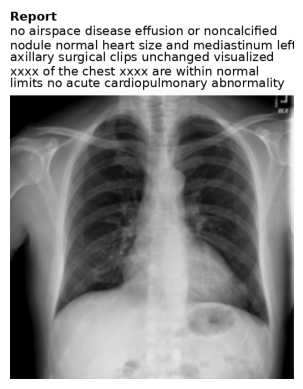

In [426]:
xray_plotable = (xray[0] * 255).numpy().astype(np.uint8)
plot_text_and_image(report, "Report", xray_plotable)